<a href="https://colab.research.google.com/github/hmeyer/flow_matching/blob/main/Mnist_Discrete_Flow_Matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
!pip install -q mediapy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.1 MB/s eta 0:00:00


## Imports

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset
import numpy as np
from tqdm.auto import tqdm
import math
from mediapy import show_image, show_images, show_video
import time
from collections import defaultdict
import einops

## Setup Accelerator

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

using device: cuda


## Num Classes

In [4]:
N_GRAYSCALES = 4

## Prepare dataset

In [5]:
class QuantizeToNGrayscales:

    def __init__(self, num_grayscales: int):
        self.num_grayscales = num_grayscales

    def __call__(self, tensor_image: torch.Tensor) -> torch.Tensor:
        scaled_image = tensor_image * (self.num_grayscales - 1)
        return torch.round(scaled_image).to(torch.int32).squeeze(0)


transform_quantize = T.Compose([
    T.ToTensor(),
    QuantizeToNGrayscales(N_GRAYSCALES)
])

train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True,
    transform=transform_quantize
)

test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True,
    transform=transform_quantize
)

# train_dataset = torchvision.datasets.MNIST(
#     root='./data', train=True, download=True,
#     transform=transforms.ToTensor() # Keep as continuous initially
# )
# test_dataset = torchvision.datasets.MNIST(
#     root='./data', train=False, download=True,
#     transform=transforms.ToTensor()
# )
test_dataset = Subset(test_dataset, range(1_000))

batch_size = 32

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size * 2, shuffle=False, pin_memory=True
)
print()
print("train - showing original continuous images")
temp_batch = next(iter(train_loader))[0]
show_images(temp_batch.to(torch.uint32)) # This will show continuous images
print(f"Example pixel values from train_loader (continuous): {temp_batch.min()}, {temp_batch.max()}")

print("test - showing original continuous images")
temp_batch_test = next(iter(test_loader))[0]
show_images(temp_batch_test.to(torch.uint32))

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 529kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.53MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.67MB/s]



train - showing original continuous images


,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


Example pixel values from train_loader (continuous): 0, 3
test - showing original continuous images


,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


## Flow Matching Model

In [6]:
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = t[:, None] * embeddings[None, :]
        if self.dim % 2 == 1: # zero pad if dim is odd for a final concat
            pad_tensor = torch.zeros((embeddings.shape[0], 1), device=device)
            embeddings = torch.cat((embeddings.sin(), embeddings.cos(), pad_tensor), dim=-1)
        else:
            embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class MLP(nn.Module):
    def __init__(self, time_embedding_dim, hidden_dim, out_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(time_embedding_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, t_emb):
        return self.mlp(t_emb)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim=None, num_groups=8):
        super().__init__()

        def get_effective_groups(channels, requested_groups):
            if channels == 0: return 1 # Should not happen with >0 channels
            # Find largest divisor of channels that is <= requested_groups
            # Default to 1 if no other common divisor or too few channels.
            if channels < requested_groups and channels > 0 : # If channels < num_groups, each channel is a group or 1 group
                 return channels # Group per channel is often max useful grouping here.
                                # Or, if channels is small (e.g. 1,2,3) use 1 group.
                                # Let's be robust: use min(channels, requested_groups) then ensure divisibility

            eff_groups = min(channels, requested_groups) if channels > 0 else 1
            while eff_groups > 0 and channels % eff_groups != 0:
                eff_groups -=1
            return eff_groups if eff_groups > 0 else 1 # Fallback to 1 group

        effective_num_groups = get_effective_groups(out_channels, num_groups)


        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.norm1 = nn.GroupNorm(num_groups=effective_num_groups, num_channels=out_channels) if out_channels > 0 else nn.Identity()
        self.act1 = nn.SiLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.norm2 = nn.GroupNorm(num_groups=effective_num_groups, num_channels=out_channels) if out_channels > 0 else nn.Identity()
        self.act2 = nn.SiLU()

        self.time_proj = nn.Linear(time_emb_dim, out_channels) if time_emb_dim is not None and time_emb_dim > 0 else None
        self.res_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, t_emb=None):
        h = self.conv1(x)
        h = self.norm1(h)

        if self.time_proj is not None and t_emb is not None:
            time_cond = self.time_proj(t_emb)
            if time_cond is not None:
                h = h + time_cond[:, :, None, None]

        h = self.act1(h)
        h = self.conv2(h)
        h = self.norm2(h)
        h = self.act2(h)
        return h + self.res_conv(x)


class SelfAttentionBlock(nn.Module):
    def __init__(self, channels, num_heads=4):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=channels, num_heads=num_heads, batch_first=True)

    def forward(self, x):
      s = x.shape
      t = einops.rearrange(x, 'b c h w -> b (h w) c')
      t = self.attn(t, t, t)[0]
      return x + einops.rearrange(t, 'b (h w) c -> b c h w', c=s[1], h=s[2])



class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim=None, num_groups_norm=8):
        super().__init__()
        self.conv = ConvBlock(in_channels, out_channels, time_emb_dim, num_groups_norm)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x, t_emb=None):
        x_pre_conv = self.pool(x)
        x_post_conv = self.conv(x_pre_conv, t_emb)
        return x_post_conv

class UpBlock(nn.Module):
    def __init__(self, in_channels_prev_up, channels_from_skip, out_channels_conv, time_emb_dim, num_groups_norm):
        super().__init__()
        self.up_conv_transpose = nn.ConvTranspose2d(in_channels_prev_up, in_channels_prev_up // 2, kernel_size=2, stride=2)
        self.conv = ConvBlock( (in_channels_prev_up // 2) + channels_from_skip, out_channels_conv, time_emb_dim, num_groups_norm)

    def forward(self, x_prev_up, x_skip, t_emb):
        x_upsampled = self.up_conv_transpose(x_prev_up)

        if x_upsampled.shape[2:] != x_skip.shape[2:]:
            diffY = x_skip.size(2) - x_upsampled.size(2)
            diffX = x_skip.size(3) - x_upsampled.size(3)
            x_upsampled = F.pad(x_upsampled, [diffX // 2, diffX - diffX // 2,
                                           diffY // 2, diffY - diffY // 2])

        x_cat = torch.cat([x_upsampled, x_skip], dim=1)
        x = self.conv(x_cat, t_emb)
        return x


class UNetMNIST(nn.Module):
    def __init__(self,
                 num_pixel_classes=1, # Changed from out_channels for discrete output
                 base_channels=32,
                 time_embedding_dim=128,
                 time_mlp_hidden_dim=512,
                 num_groups_norm=8,
                 use_attention_bottleneck=True):
        super().__init__()

        self.num_pixel_classes = num_pixel_classes
        self.embedding = nn.Embedding(num_pixel_classes, base_channels)

        if base_channels <= 0:
            raise ValueError("base_channels must be positive.")
        if time_embedding_dim <= 0 and time_mlp_hidden_dim > 0 :
             time_embedding_dim = 0
             time_mlp_hidden_dim = 0

        self.time_embedding = SinusoidalTimeEmbedding(time_embedding_dim) if time_embedding_dim > 0 else nn.Identity()
        self.time_mlp = MLP(time_embedding_dim, time_mlp_hidden_dim, time_embedding_dim) if time_embedding_dim > 0 else nn.Identity()

        self.conv_in = ConvBlock(base_channels, base_channels, time_embedding_dim, num_groups_norm)
        self.down1 = DownBlock(base_channels, base_channels * 2, time_embedding_dim, num_groups_norm)
        self.down2 = DownBlock(base_channels * 2, base_channels * 4, time_embedding_dim, num_groups_norm)
        self.bottleneck_conv1 = ConvBlock(base_channels * 4, base_channels * 8, time_embedding_dim, num_groups_norm)
        if use_attention_bottleneck:
            self.attention = SelfAttentionBlock(base_channels * 8, num_heads=4)
        else:
            self.attention = nn.Identity()
        self.bottleneck_conv2 = ConvBlock(base_channels * 8, base_channels * 4, time_embedding_dim, num_groups_norm)
        self.up1 = UpBlock(in_channels_prev_up=base_channels * 4, channels_from_skip=base_channels * 2, out_channels_conv=base_channels * 2, time_emb_dim=time_embedding_dim, num_groups_norm=num_groups_norm)
        self.up2 = UpBlock(in_channels_prev_up=base_channels * 2, channels_from_skip=base_channels, out_channels_conv=base_channels, time_emb_dim=time_embedding_dim, num_groups_norm=num_groups_norm)
        self.conv_out = nn.Conv2d(base_channels, self.num_pixel_classes, kernel_size=1)

    def forward(self, x, t):
        x = self.embedding(x)
        x = einops.rearrange(x, "b h w d -> b d h w")
        if isinstance(self.time_embedding, nn.Identity) or t is None:
            t_emb = None
        else:
            t_emb_sin = self.time_embedding(t)
            t_emb = self.time_mlp(t_emb_sin)

        s1_skip = self.conv_in(x, t_emb)
        s2_skip = self.down1(s1_skip, t_emb)
        s3_features = self.down2(s2_skip, t_emb)

        b = self.bottleneck_conv1(s3_features, t_emb)
        b = self.attention(b)
        b = self.bottleneck_conv2(b, t_emb)

        u1 = self.up1(b, s2_skip, t_emb)
        u2 = self.up2(u1, s1_skip, t_emb)

        out_logits = self.conv_out(u2)
        return out_logits

## Flow Matching Loss and sampling

In [7]:
def flow_matching_loss(model, batch, K=N_GRAYSCALES):
    """
    Discrete Flow Matching Loss.
    Trains model to predict x0 (clean data) from interpolated state x_t.
    x_t = (1-t)*x0 + t*x1 with probability mixing.
    The model learns to "undo" the noise and recover the clean data.
    """
    x0_discrete = batch[0].to(next(model.parameters()).device)
    batch_size, H, W = x0_discrete.shape

    # Sample random time and noise
    t_scalar = torch.rand((batch_size,), device=x0_discrete.device)
    t_broadcast = t_scalar.view(batch_size, 1, 1)
    x1_discrete = torch.randint(0, K, size=(batch_size, H, W), device=x0_discrete.device, dtype=torch.long)

    # Create interpolated state: x_t = (1-t)*x0 + t*x1
    # With probability (1-t), use x0; with probability t, use x1
    mask = torch.rand((batch_size, H, W), device=x0_discrete.device) < t_broadcast
    x_t_discrete = torch.where(mask, x1_discrete, x0_discrete)

    # Model predicts x0 (clean data) from x_t
    # This is the key: we learn to recover the data distribution
    logits_pred_x0 = model(x_t_discrete, t_scalar)

    # Target: predict the clean data x0
    x0_target = x0_discrete
    loss = F.cross_entropy(logits_pred_x0, x0_target.to(torch.int64))
    return {"loss": loss}


@torch.no_grad()
def sample_batch(model, initial_noise_discrete, num_steps=10, K=N_GRAYSCALES):
    """
    Sample by integrating the learned flow from noise (x1) to data (x0).
    We start from noise and gradually transition to the predicted clean data.
    """
    model.eval()
    device = next(model.parameters()).device
    x_t_discrete = initial_noise_discrete.clone().to(device)

    for i in range(num_steps):
        # Time goes from 1 to 0 (backwards, from noise to data)
        t_current = 1.0 - (i / num_steps)
        t_for_model_nn = torch.full((x_t_discrete.shape[0],), t_current, device=device, dtype=torch.float)

        # Predict clean data x0 from current noisy state
        logits_x0_pred = model(x_t_discrete, t_for_model_nn)

        # Sample predicted clean data
        b, _, h, w = logits_x0_pred.shape
        flat_logits = einops.rearrange(logits_x0_pred, "b c h w -> (b h w) c")
        flat_probs = F.softmax(flat_logits, dim=-1)
        flat_x0 = torch.multinomial(flat_probs, num_samples=1)
        x0_pred = einops.rearrange(flat_x0, "(b h w) 1 -> b h w", b=b, h=h, w=w)

        # Flow from noise towards predicted clean data
        # As t decreases, we should have more of x0 and less noise
        # Probability of transitioning to x0 increases as we approach t=0
        dt = 1.0 / num_steps
        transition_prob = dt / t_current if t_current > 0 else 1.0
        transition_prob = min(transition_prob, 1.0)

        mask = torch.rand_like(x_t_discrete, dtype=torch.float) < transition_prob
        x_t_discrete = torch.where(mask, x0_pred, x_t_discrete)

    return x_t_discrete.squeeze(1)

## Trainer

In [8]:
class TrainLossLogger:
  def __init__(self, log_every_sec=10.0) -> None:
    self.running = defaultdict(list)
    self.log_every_sec = log_every_sec
    self.last_log = time.time()

  def log(self, data) -> None:
    for k, v in data.items():
      self.running[k].append(v)
    if self.last_log + self.log_every_sec < time.time():
      self.last_log = time.time()
      print("mean train:", {k: float(np.array(v).mean()) for k, v in self.running.items()})
      self.running = defaultdict(list)


class Trainer:
    def __init__(self, *, model, train_loader, test_loader, loss_fn, extra_eval_fn=None, num_epochs=5, batch_size=32):
        self.model = model
        self.device = next(model.parameters()).device
        self.loss_fn = loss_fn
        self.extra_eval_fn = extra_eval_fn
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.train_loader = train_loader
        self.test_loader = test_loader

    def train(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        loss_logger = TrainLossLogger()

        for epoch in range(self.num_epochs):
            print(f"epoch={epoch} test {self.eval()}")
            if self.extra_eval_fn:
                self.extra_eval_fn(self.model)

            self.model.train()
            prog_bar = tqdm(enumerate(self.train_loader), desc=f"Epoch {epoch + 1}/{self.num_epochs}", total=len(self.train_loader), unit=" batches")
            for i, batch in prog_bar:
                optimizer.zero_grad()
                loss_dict = self.loss_fn(self.model, batch)
                loss = loss_dict["loss"]
                loss.backward()
                optimizer.step()
                log_items = {k: v.item() for k, v in loss_dict.items()}
                loss_logger.log(log_items)
                prog_bar.set_postfix(log_items)

        print(f"epoch={epoch} test {self.eval()}") # Final eval after last epoch
        if self.extra_eval_fn:
            self.extra_eval_fn(self.model)

    @torch.no_grad()
    def eval(self) -> float:
        torch.manual_seed(17)

        self.model.eval()
        total_loss_vals = defaultdict(list)
        for batch in self.test_loader:
            loss_dict = self.loss_fn(self.model, batch)
            for k, v in loss_dict.items():
              total_loss_vals[k].append(v.item())

        torch.random.seed()
        return {k: float(np.array(v).mean()) for k, v in total_loss_vals.items()}

## Train the Flow Matching model

In [9]:
fm_model = UNetMNIST(num_pixel_classes=N_GRAYSCALES, base_channels=32)
fm_model.to(device)

def sample_and_viz(model_to_eval):
  torch.manual_seed(1)
  # Start from random noise
  initial_noise = torch.randint(0, N_GRAYSCALES, (20, 28, 28),
                                dtype=torch.long, device=device)
  imgs = sample_batch(model_to_eval, initial_noise, num_steps=20, K=N_GRAYSCALES)
  show_images(imgs.cpu().to(torch.uint8))
  print(f"Generated sample images (min/max): {imgs.min()}/{imgs.max()}")
  torch.random.seed()

trainer_fm = Trainer(model=fm_model,
                  train_loader=train_loader,
                  test_loader=test_loader,
                  loss_fn=flow_matching_loss,
                  extra_eval_fn=sample_and_viz,
                  num_epochs=5)
trainer_fm.train()

epoch=0 test {'loss': 1.5255780145525932}


,,,,,,,,,,,,,,,,,,,


Generated sample images (min/max): 0/3


Epoch 1/5:   0%|          | 0/1875 [00:00<?, ? batches/s]

mean train: {'loss': 0.2749383008823945}
mean train: {'loss': 0.21674268645484274}
mean train: {'loss': 0.20309876817755582}
mean train: {'loss': 0.2022771290128265}
epoch=1 test {'loss': 0.18893811758607626}


,,,,,,,,,,,,,,,,,,,


Generated sample images (min/max): 0/3


Epoch 2/5:   0%|          | 0/1875 [00:00<?, ? batches/s]

mean train: {'loss': 0.19659367896071295}
mean train: {'loss': 0.19726486744011862}
mean train: {'loss': 0.19441241427248226}
mean train: {'loss': 0.1941788645945196}
mean train: {'loss': 0.19190499273108513}
epoch=2 test {'loss': 0.1825396465137601}


,,,,,,,,,,,,,,,,,,,


Generated sample images (min/max): 0/3


Epoch 3/5:   0%|          | 0/1875 [00:00<?, ? batches/s]

mean train: {'loss': 0.1929872576783343}
mean train: {'loss': 0.19061227845192524}
mean train: {'loss': 0.1918152292767665}
mean train: {'loss': 0.19147079385143037}
mean train: {'loss': 0.18882178203225722}
epoch=3 test {'loss': 0.17829184234142303}


,,,,,,,,,,,,,,,,,,,


Generated sample images (min/max): 0/3


Epoch 4/5:   0%|          | 0/1875 [00:00<?, ? batches/s]

mean train: {'loss': 0.18955784674257273}
mean train: {'loss': 0.18836192001124083}
mean train: {'loss': 0.18704657885763382}
mean train: {'loss': 0.18459265835878283}
epoch=4 test {'loss': 0.1774063315242529}


,,,,,,,,,,,,,,,,,,,


Generated sample images (min/max): 0/3


Epoch 5/5:   0%|          | 0/1875 [00:00<?, ? batches/s]

mean train: {'loss': 0.18570512112068094}
mean train: {'loss': 0.18778020158262537}
mean train: {'loss': 0.18426468225124365}
mean train: {'loss': 0.18404149201109213}
mean train: {'loss': 0.18463203338493267}
epoch=4 test {'loss': 0.17528102546930313}


,,,,,,,,,,,,,,,,,,,


Generated sample images (min/max): 0/3


## Simple Guidance (just brightness)

Intensity Guidance:   0%|          | 0/30 [00:00<?, ?guidance_steps/s]

""

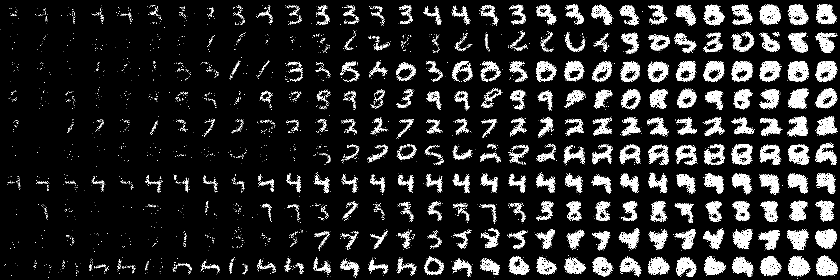

In [10]:
@torch.no_grad()
def sample_with_guidance(model, initial_data_discrete, guidance_fn, guidance_scale,
                         num_steps=10, K=N_GRAYSCALES, num_guidance_samples=10):
    """
    Sample with guidance for flow matching.
    We want to guide the final generated image, so we apply guidance to the
    predicted x1 at each step.
    """
    model.eval()
    device = next(model.parameters()).device
    x_t_discrete = initial_data_discrete.clone().to(device)

    for i in range(num_steps):
        # Time goes from 0 to 1
        t_current = i / num_steps
        t_for_model_nn = torch.full((x_t_discrete.shape[0],), t_current, device=device, dtype=torch.float)

        # Predict x1 from current x_t
        logits_pred_x1 = model(x_t_discrete, t_for_model_nn)

        # Apply guidance: we want to guide towards certain properties at t=1 (final state)
        # Since we're predicting x1, we can directly apply guidance to these logits
        grad_wrt_logits = torch.zeros_like(logits_pred_x1)
        for _ in range(num_guidance_samples):
            with torch.enable_grad():
                logits_for_guidance = logits_pred_x1.clone().requires_grad_(True)
                onehots_for_guidance = F.gumbel_softmax(logits_for_guidance, dim=1)
                scores = guidance_fn(onehots_for_guidance)
                grad_wrt_logits += torch.autograd.grad(scores.sum(), logits_for_guidance)[0].detach()
        grad_wrt_logits /= num_guidance_samples

        logits_guided = logits_pred_x1 + guidance_scale * grad_wrt_logits

        # Sample x1 from guided distribution
        b, _, h, w = logits_guided.shape
        flat_logits = einops.rearrange(logits_guided, "b c h w -> (b h w) c")
        flat_probs = F.softmax(flat_logits, dim=-1)
        flat_discrete = torch.multinomial(flat_probs, num_samples=1)
        x1_sample = einops.rearrange(flat_discrete, "(b h w) 1 -> b h w", b=b, h=h, w=w)

        # Step towards x1
        dt = 1.0 / num_steps
        step_prob = dt / (1 - t_current) if t_current < 1.0 else 1.0
        step_prob = min(step_prob, 1.0)

        mask = torch.rand_like(x_t_discrete, dtype=torch.float) < step_prob
        x_t_discrete = torch.where(mask, x1_sample, x_t_discrete)

    return x_t_discrete.squeeze(1)


def intensity_objective(x):
  num_classes = x.shape[1]
  pixel_values_tensor = torch.arange(num_classes, device=device, dtype=torch.float32).view(1, num_classes, 1, 1)
  expected_img_values = torch.sum(x * pixel_values_tensor, dim=1)
  return expected_img_values.mean()


def intensity_guidance_viz(model_to_guide, steps=30, num_examples=10, K_val=N_GRAYSCALES):
  device = next(model_to_guide.parameters()).device
  torch.manual_seed(1)
  device_viz = next(model_to_guide.parameters()).device
  initial_noise = torch.randint(0, K_val, (num_examples, 28, 28), dtype=torch.long, device=device_viz)

  images = []
  for s in tqdm(range(steps), total=steps, unit="guidance_steps", desc="Intensity Guidance"):
    scale = torch.tensor(s / (steps - 1)) * 2 - 1
    scale *= 3e4

    sampled_imgs = sample_with_guidance(
        model_to_guide, initial_data_discrete=initial_noise, guidance_fn=intensity_objective,
        guidance_scale=scale, num_steps=20, K=K_val)
    images.append(sampled_imgs.cpu())

  torch.random.seed()

  i = torch.stack(images, axis=0).to(torch.uint8)
  i = einops.rearrange(i, "r c w h -> (c w) (r h)")
  show_image(i)

intensity_guidance_viz(fm_model)

## Classifier Model

In [11]:
class MNISTClassifier(nn.Module):
    def __init__(self,
                 num_classes=10, base_channels=32,
                 num_groups_norm=8, use_attention_bottleneck=True,
                 K_pixel_input=N_GRAYSCALES):
        super().__init__()
        if base_channels <= 0:
            raise ValueError("base_channels must be positive.")
        self.embedding = nn.Conv2d(K_pixel_input, base_channels, kernel_size=1, padding=0)
        self.conv_in = ConvBlock(base_channels, base_channels, time_emb_dim=None, num_groups=num_groups_norm)
        self.down1 = DownBlock(base_channels, base_channels * 2, time_emb_dim=None, num_groups_norm=num_groups_norm)
        self.down2 = DownBlock(base_channels * 2, base_channels * 4, time_emb_dim=None, num_groups_norm=num_groups_norm)
        self.bottleneck_conv1 = ConvBlock(base_channels * 4, base_channels * 8, time_emb_dim=None, num_groups=num_groups_norm)
        if use_attention_bottleneck:
            self.attention = SelfAttentionBlock(base_channels * 8, num_heads=4)
        else:
            self.attention = nn.Identity()
        bottleneck_out_channels = base_channels * 8
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier_head = nn.Linear(bottleneck_out_channels, num_classes)
        self.num_pixel_classes = K_pixel_input

    def forward(self, x):
        x = x.to(torch.long)
        x = F.one_hot(x, num_classes=self.num_pixel_classes).to(torch.float32)
        x = einops.rearrange(x, "b h w d -> b d h w")
        return self.forward_onehot(x)

    def forward_onehot(self, x):
        h = self.embedding(x)
        h = self.conv_in(h, t_emb=None)
        h = self.down1(h, t_emb=None)
        h = self.down2(h, t_emb=None)
        h = self.bottleneck_conv1(h, t_emb=None)
        h = self.attention(h)
        h = self.global_avg_pool(h)
        h = torch.flatten(h, 1)
        out_logits = self.classifier_head(h)
        return out_logits


## CE Loss

In [12]:
def ce_loss_classifier(model, batch, K_pixel_val=N_GRAYSCALES):
    x = batch[0].to(next(model.parameters()).device)
    y_digit_labels = batch[1].to(next(model.parameters()).device)
    y_logits_pred = model(x)
    loss = nn.CrossEntropyLoss()(y_logits_pred, y_digit_labels)
    predicted_classes = torch.argmax(y_logits_pred, dim=1)
    accuracy = (predicted_classes == y_digit_labels).float().mean()
    return dict(loss=loss, accuracy=accuracy)


## Train the classifier

In [13]:
classifier_model = MNISTClassifier(K_pixel_input=N_GRAYSCALES)
classifier_model.to(device)
trainer_classifier = Trainer(
    model=classifier_model, train_loader=train_loader, test_loader=test_loader,
    loss_fn=ce_loss_classifier, extra_eval_fn=None, num_epochs=1 )
trainer_classifier.train()

epoch=0 test {'loss': 2.366823688149452, 'accuracy': 0.12773437518626451}


Epoch 1/1:   0%|          | 0/1875 [00:00<?, ? batches/s]

mean train: {'loss': 0.583968409161591, 'accuracy': 0.7956281833616299}
mean train: {'loss': 0.12996772855260952, 'accuracy': 0.9603068369028006}
mean train: {'loss': 0.08934130157858523, 'accuracy': 0.9739415322580646}
epoch=0 test {'loss': 0.1185519474092871, 'accuracy': 0.9626953117549419}


## Classifier Guidance

  0%|          | 0/10 [00:00<?, ?it/s]

""

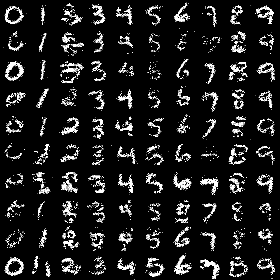

In [14]:
def class_scorer(classifier_nn, x, class_weights):
    digit_logits = classifier_nn.forward_onehot(x)
    log_probs_digits = F.log_softmax(digit_logits, dim=-1)
    score = (log_probs_digits * class_weights[None, :]).sum(dim=-1).mean()
    return score


def number_guidance(model_to_guide, classifier_model, num_examples=10, K_val=N_GRAYSCALES):
  torch.manual_seed(1)
  device_viz = next(model_to_guide.parameters()).device
  initial_noise = torch.randint(0, K_val, (num_examples, 28, 28), dtype=torch.long, device=device_viz)


  images = []
  for n in tqdm(range(10)):
    one_hot = F.one_hot(torch.tensor(n), 10).to(device)
    def scorer(x):
      return class_scorer(classifier_model, x, one_hot)
    sampled_imgs = sample_with_guidance(
      fm_model, initial_data_discrete=initial_noise, guidance_fn=scorer,
      guidance_scale=1e4, num_steps=100, K=N_GRAYSCALES)
    images.append(sampled_imgs.cpu())
  i = torch.stack(images, axis=0).to(torch.uint8)
  i = einops.rearrange(i, "r c w h -> (c w) (r h)")
  show_image(i)


number_guidance(fm_model, classifier_model)

Generating for digits:   0%|          | 0/10 [00:00<?, ?it/s]

Generating for brightness (digit 0):   0%|          | 0/10 [00:00<?, ?it/s]

Generating for brightness (digit 1):   0%|          | 0/10 [00:00<?, ?it/s]

Generating for brightness (digit 2):   0%|          | 0/10 [00:00<?, ?it/s]

Generating for brightness (digit 3):   0%|          | 0/10 [00:00<?, ?it/s]

Generating for brightness (digit 4):   0%|          | 0/10 [00:00<?, ?it/s]

Generating for brightness (digit 5):   0%|          | 0/10 [00:00<?, ?it/s]

Generating for brightness (digit 6):   0%|          | 0/10 [00:00<?, ?it/s]

Generating for brightness (digit 7):   0%|          | 0/10 [00:00<?, ?it/s]

Generating for brightness (digit 8):   0%|          | 0/10 [00:00<?, ?it/s]

Generating for brightness (digit 9):   0%|          | 0/10 [00:00<?, ?it/s]

""

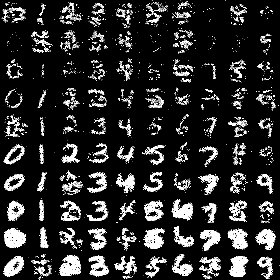

In [15]:
# prompt: make it a 10x10 grid. columns for digits, rows for brightness

def combined_guidance(model_to_guide, classifier_model, num_examples_per_cell=1, K_val=N_GRAYSCALES):
  torch.manual_seed(1)
  device_viz = next(model_to_guide.parameters()).device

  digit_scale = 1e4 # Adjust digit guidance scale as needed
  brightness_scale = 5e3 # Adjust brightness guidance scale as needed

  n_brightness_steps = 10
  images_grid = []

  for digit_label in tqdm(range(10), desc="Generating for digits"): # Rows for digits
      row_images = []
      one_hot_digit = F.one_hot(torch.tensor(digit_label), 10).to(device)

      for brightness_level in tqdm(range(n_brightness_steps), desc=f"Generating for brightness (digit {digit_label})", leave=False): # Columns for brightness
          effective_brightness_scale = torch.tensor(brightness_level / (n_brightness_steps - 1)) * 2 - 1
          effective_brightness_scale *= brightness_scale


          # Initial noise for each cell in the grid
          initial_noise = torch.randint(0, K_val, (num_examples_per_cell, 28, 28), dtype=torch.long, device=device_viz)


          def combined_scorer(x):
              # Classifier guidance for the digit
              digit_score = class_scorer(classifier_model, x, one_hot_digit)
              brightness_score = intensity_objective(x)
              return digit_scale * digit_score + effective_brightness_scale * brightness_score # Sum the scores


          sampled_imgs = sample_with_guidance(
            fm_model, initial_data_discrete=initial_noise, guidance_fn=combined_scorer,
            guidance_scale=1.0, # The scales are now inside the combined_scorer
            num_steps=32, K=N_GRAYSCALES, num_guidance_samples=5) # Reduced guidance samples for speed

          row_images.append(sampled_imgs.cpu().squeeze(0))

      images_grid.append(torch.cat(row_images, dim=0)) # Concatenate images horizontally for the row

  # Concatenate all rows vertically
  final_grid = torch.cat(images_grid, dim=1)

  torch.random.seed()
  show_image(final_grid.to(torch.uint8))


combined_guidance(fm_model, classifier_model, num_examples_per_cell=1)